In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, roc_auc_score, precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt
import polars as pl
import gc
import os
import time
from datetime import timedelta
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [2]:
gc.collect()

0

# Data preperation

In [3]:
probka = pl.read_csv('.\\danonki\\1472_all_confidence.csv', n_rows=50, ignore_errors=True)
kolumny = probka.columns
reference_schema = probka.schema

def cast_to_reference_schema_special(df, reference_schema):
    return df.with_columns([
        # Jeśli docelowy typ to Int64, wykonaj najpierw cast na Float64, a potem na Int64
        pl.col(col_name).cast(pl.Float64).cast(pl.Int64) if reference_schema[col_name] == pl.Int64 
        else pl.col(col_name).cast(reference_schema[col_name])  # Dla pozostałych kolumn wykonaj zwykłe rzutowanie
        for col_name in df.columns if col_name in reference_schema
    ])


folder_path = '.\\danonki'
file_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.csv')]

# Lista przechowująca przetworzone ramki danych
dane_lazy_frames = []
 
#Przetwarzanie plików
for i, path in enumerate(file_paths):
    print(f"Przetwarzanie pliku {i + 1}/{len(file_paths)}: {path}")

    # Lazy load ramki z rzutowaniem
    dane_lazy = (
        pl.scan_csv(path, ignore_errors=True)
    )

    dane_lazy = cast_to_reference_schema_special(dane_lazy, reference_schema)
 
    dane_lazy_frames.append(dane_lazy)

# Konkatenacja wszystkich ramek danych
dane_combined_lazy = pl.concat(dane_lazy_frames, how="vertical")

# Zmaterializowanie połączonych danych
final_data = dane_combined_lazy.collect()

Przetwarzanie pliku 1/12: .\danonki\1472_all_confidence.csv
Przetwarzanie pliku 2/12: .\danonki\2004_data_confidence.csv
Przetwarzanie pliku 3/12: .\danonki\2500_data_confidence.csv
Przetwarzanie pliku 4/12: .\danonki\2582_all_confidence.csv
Przetwarzanie pliku 5/12: .\danonki\3839_data_confidence.csv
Przetwarzanie pliku 6/12: .\danonki\4614_data_confidence.csv
Przetwarzanie pliku 7/12: .\danonki\4953_data_confidence.csv
Przetwarzanie pliku 8/12: .\danonki\5656_data_confidence.csv
Przetwarzanie pliku 9/12: .\danonki\6139_data_confidence.csv
Przetwarzanie pliku 10/12: .\danonki\6241_data_confidence.csv
Przetwarzanie pliku 11/12: .\danonki\6601_data_confidence.csv
Przetwarzanie pliku 12/12: .\danonki\7501_data_confidence.csv


C:\Users\user\AppData\Local\Temp\ipykernel_6376\1905424641.py:10: PerformanceWarning: Determining the column names of a LazyFrame requires resolving its schema, which is a potentially expensive operation. Use `LazyFrame.collect_schema().names()` to get the column names without this warning.
  for col_name in df.columns if col_name in reference_schema


In [4]:
time.sleep(4)

In [5]:
probka = pl.read_csv('.\\danonki\\1472_all_confidence.csv', n_rows=50, ignore_errors=True)
kolumny = probka.columns
reference_schema = probka.schema

def cast_to_reference_schema_special(df, reference_schema):
    return df.with_columns([
        # Jeśli docelowy typ to Int64, wykonaj najpierw cast na Float64, a potem na Int64
        pl.col(col_name).cast(pl.Float64).cast(pl.Int64) if reference_schema[col_name] == pl.Int64 
        else pl.col(col_name).cast(reference_schema[col_name])  # Dla pozostałych kolumn wykonaj zwykłe rzutowanie
        for col_name in df.columns if col_name in reference_schema
    ])


folder_path = '.\\danonki2'
file_paths = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.csv')]

# Lista przechowująca przetworzone ramki danych
dane_lazy_frames = []
 
#Przetwarzanie plików
for i, path in enumerate(file_paths):
    print(f"Przetwarzanie pliku {i + 1}/{len(file_paths)}: {path}")

    # Lazy load ramki z rzutowaniem
    dane_lazy = (
        pl.scan_csv(path, ignore_errors=True)
    )

    dane_lazy = cast_to_reference_schema_special(dane_lazy, reference_schema)
 
    dane_lazy_frames.append(dane_lazy)

# Konkatenacja wszystkich ramek danych
dane_combined_lazy2 = pl.concat(dane_lazy_frames, how="vertical")

# Zmaterializowanie połączonych danych
final_data2 = dane_combined_lazy2.collect()

Przetwarzanie pliku 1/11: .\danonki2\0681_data_confidence.csv
Przetwarzanie pliku 2/11: .\danonki2\1153_data_confidence.csv
Przetwarzanie pliku 3/11: .\danonki2\1981_all_confidence.csv
Przetwarzanie pliku 4/11: .\danonki2\6754_data_confidence.csv
Przetwarzanie pliku 5/11: .\danonki2\7297_data_confidence.csv
Przetwarzanie pliku 6/11: .\danonki2\7379_data_confidence.csv
Przetwarzanie pliku 7/11: .\danonki2\8193_data_confidence.csv
Przetwarzanie pliku 8/11: .\danonki2\8281_data_confidence.csv
Przetwarzanie pliku 9/11: .\danonki2\8779_data_confidence.csv
Przetwarzanie pliku 10/11: .\danonki2\8866_data_confidence.csv
Przetwarzanie pliku 11/11: .\danonki2\9813_data_confidence.csv


C:\Users\user\AppData\Local\Temp\ipykernel_6376\959448906.py:10: PerformanceWarning: Determining the column names of a LazyFrame requires resolving its schema, which is a potentially expensive operation. Use `LazyFrame.collect_schema().names()` to get the column names without this warning.
  for col_name in df.columns if col_name in reference_schema


In [6]:
del dane_combined_lazy, dane_combined_lazy2 , dane_lazy, dane_lazy_frames, file_paths, folder_path, i, kolumny, path, reference_schema

In [7]:
df = pl.concat([final_data, final_data2], how="vertical")

In [8]:
del final_data, final_data2

In [9]:
gc.collect()

0

In [10]:
del probka, 

In [11]:
df.group_by(["label" ]).agg(pl.col("label").count().alias("count")).sort('label')

label,count
str,u32
"""depression""",1960557
"""euthymia""",2144341
"""mania""",1824108
"""mixed""",1085154


In [12]:
stat_rec = df.group_by(["label",'patient_id']).agg(pl.col("label").count().alias("count")).sort('label')

### Uzupełnienie brakujących wartości ZERAMI

In [13]:
df = df.fill_null(0)

## Dołączenie symptomów

In [14]:
visits = pl.read_csv('wizyty.csv',  ignore_errors=True)

#columns_to_check = [col for col in visits.columns if "yms_suma" in col or "hamd_suma" in col]
visits = visits.filter(~(pl.col('yms_suma')== 'NA' ))
visits = visits.filter(~(pl.col('hamd_suma')== 'NA' ))

visits =  visits.with_columns([
    pl.col("hamd_anxiety").cast(pl.Int64),
    pl.col("hamd_fearMentalSymptoms").cast(pl.Int64),
    pl.col("hamd_inhibition").cast(pl.Int64),
    pl.col("hamd_workAndInterests").cast(pl.Int64),
    pl.col("hamd_criticism").cast(pl.Int64),
    pl.col("hamd_depressingMood").cast(pl.Int64),
    pl.col("hamd_feelingGuilty").cast(pl.Int64),
    pl.col("yms_appearance").cast(pl.Int64),
    pl.col("yms_formalThoughtsDisorder").cast(pl.Int64),
    pl.col("yms_thoughtsDisorder").cast(pl.Int64),
    pl.col("yms_view").cast(pl.Int64),
    pl.col("yms_increasedActivity").cast(pl.Int64),
    pl.col("yms_speech").cast(pl.Int64),
    pl.col("yms_elevatedMood").cast(pl.Int64),
    pl.col("yms_destructiveBehavior").cast(pl.Int64),
    pl.col("yms_irritability").cast(pl.Int64),
    pl.col("hamd_earlyAwakening").cast(pl.Int64),
    pl.col("hamd_intermittentSleep").cast(pl.Int64),
    pl.col("hamd_sleepDisorder").cast(pl.Int64),
    pl.col("yms_sleep").cast(pl.Int64),
    pl.col("hamd_fearSomaticSymptoms").cast(pl.Int64),
    pl.col("hamd_genericSomaticSymptoms").cast(pl.Int64),
    pl.col("hamd_hypochondria").cast(pl.Int64),
    pl.col("hamd_suicidalTendencies").cast(pl.Int64)
])

# Calculate the new columns by summing the specific columns for each row
visits = visits.with_columns([
    (pl.col("hamd_anxiety") + pl.col("hamd_fearMentalSymptoms")).alias("anxiety"),
    (pl.col("hamd_inhibition") + pl.col("hamd_workAndInterests")).alias("decreased_activity"),
    (pl.col("hamd_criticism") + pl.col("hamd_depressingMood") + pl.col("hamd_feelingGuilty")).alias("decreased_mood"),
    (pl.col("yms_appearance") + pl.col("yms_formalThoughtsDisorder") + pl.col("yms_thoughtsDisorder") + pl.col("yms_view")).alias("disorganization"),
    (pl.col("yms_increasedActivity") + pl.col("yms_speech")).alias("elevated_activity"),
    pl.col("yms_elevatedMood").alias("elevated_mood"),
    (pl.col("yms_destructiveBehavior") + pl.col("yms_irritability")).alias("irritability"),
    (pl.col("hamd_earlyAwakening") + pl.col("hamd_intermittentSleep") + pl.col("hamd_sleepDisorder") + pl.col("yms_sleep")).alias("sleep_disorder"),
    (pl.col("hamd_fearSomaticSymptoms") + pl.col("hamd_genericSomaticSymptoms") + pl.col("hamd_hypochondria")).alias("somatisation"),
    pl.col("hamd_suicidalTendencies").alias("suicide")
])

In [15]:
symptoms = visits.select(['patient_id', 'visit_date',
               'hamd_anxiety','hamd_inhibition',
               'hamd_criticism','yms_appearance','yms_increasedActivity',
               'yms_elevatedMood','yms_destructiveBehavior','hamd_earlyAwakening',
               'hamd_fearSomaticSymptoms','hamd_suicidalTendencies'])

In [16]:
symptoms = symptoms.with_columns([
    pl.col("visit_date").str.slice(0, 10).alias("visit_date")
])
 

In [17]:
df = df.join(symptoms, on=["patient_id", "visit_date"], how="inner")
 

### Podział zbioru na train (dzień wizyty) i test (dni wokół wizyty)

In [18]:
start_idx = df.columns.index('pcm_LOGenergy_sma')
end_idx = df.columns.index('pcm_fftMag_mfcc_12_')
    
# Select specific columns along with the dynamically sliced columns
feature_columns = df.select(df.columns[start_idx:end_idx+1 ]).columns

In [19]:
symptom_columns = df.select(df.columns[df.columns.index('hamd_anxiety'):df.columns.index('hamd_suicidalTendencies')+1 ]).columns

In [20]:
train = df.filter(pl.col('time_point') != 0)
test = df.filter(pl.col('time_point') == 0)

In [21]:
grouped_train = train.partition_by('mr')
grouped_test = test.partition_by('mr')

In [22]:
train_arrays = []
train_y = []
train_weight = []
train_symptoms = []
max_frames = 1000    # Liczba ramek do przetworzenia

for group in grouped_train:
    # Sort frames
    group_sorted = group.sort('frame_nr')  # or 'chunk_number'
    features = group_sorted.select(feature_columns).to_numpy()

    # Handle variable frame lengths
    num_frames = features.shape[0]
    if num_frames > max_frames:
        # Truncate
        features = features[:max_frames, :]
    elif num_frames < max_frames:
        # Padding with zeros
        padding = np.zeros((max_frames - num_frames, features.shape[1]))
        features = np.vstack((features, padding))

    train_arrays.append(features)
    train_y.append(group_sorted["label"].explode().unique())
    train_weight.append(group_sorted["confidence_linear"].explode().unique())
    train_symptoms.append(group_sorted.select(symptom_columns).unique())



In [23]:
time.sleep(2)

In [24]:
test_arrays = []
test_y = []
test_weight = []
test_symptoms = []
max_frames = 1000  # Liczba ramek do przetworzenia

for group in grouped_test:
    # Sort frames
    group_sorted = group.sort('frame_nr')  # or 'chunk_number'

    # Extract feature values as a NumPy array
    features = group_sorted.select(feature_columns).to_numpy()

    # Handle variable frame lengths
    num_frames = features.shape[0]
    if num_frames > max_frames:
        # Truncate
        features = features[:max_frames, :]
    elif num_frames < max_frames:
        # Padding with zeros
        padding = np.zeros((max_frames - num_frames, features.shape[1]))
        features = np.vstack((features, padding))

    test_arrays.append(features)
    test_y.append(group_sorted["label"].explode().unique())
    test_weight.append(group_sorted["confidence_linear"].explode().unique())
    test_symptoms.append(group_sorted.select(symptom_columns).unique())

In [25]:
#  (num_conversations, max_frames, num_features)
X_train = np.stack(train_arrays)
X_test = np.stack(test_arrays)

Y_train = np.stack(train_y)
Y_test = np.stack(test_y)

X_train_weight = np.stack(train_weight)
X_test_weight = np.stack(test_weight)

X_train_symptoms = pl.concat(train_symptoms)
X_test_symptoms = pl.concat(test_symptoms)

### Podział zbioru treningowego na zbiór treningowy i walidacyjny

In [26]:
from sklearn.model_selection import train_test_split

# Ustalmy zmienne
X_train, X_valid, Y_train, Y_valid, train_weights, valid_weights, train_symptoms, valid_symptoms = train_test_split(X_train, Y_train, X_train_weight, X_train_symptoms, test_size=0.25, random_state=42, stratify= Y_train)

### Transformacja danych 

In [27]:
label_mapping = {
    'euthymia': 0,
    'depression': 1,
    'mania': 2,
    'mixed': 3
}

vectorized_mapping = np.vectorize(label_mapping.get)
Y_train = vectorized_mapping(Y_train)
Y_test = vectorized_mapping(Y_test)
Y_valid = vectorized_mapping(Y_valid)
Y_train

array([[0],
       [1],
       [1],
       ...,
       [1],
       [0],
       [2]])

In [28]:
Y_train_int =  Y_train
Y_test_int =  Y_test
Y_valid_int = Y_valid

In [29]:
# Convert integer labels to one-hot encoded vectors
Y_train = to_categorical(Y_train, num_classes=4)
Y_test = to_categorical(Y_test, num_classes=4)
Y_valid = to_categorical(Y_valid, num_classes=4)

In [30]:
scaler = StandardScaler()
#X_train
X_train_scaled_flat = X_train.reshape(-1, X_train.shape[-1])
X_train_scaled_flat =  scaler.fit_transform(X_train_scaled_flat)
X_train_scaled = X_train_scaled_flat.reshape(X_train.shape)

#X_valid
X_valid_scaled_flat = X_valid.reshape(-1, X_valid.shape[-1])
X_valid_scaled_flat =  scaler.fit_transform(X_valid_scaled_flat)
X_valid_scaled = X_valid_scaled_flat.reshape(X_valid.shape)

#X_test
X_test_scaled_flat = X_test.reshape(-1, X_test.shape[-1])
X_test_scaled_flat =  scaler.fit_transform(X_test_scaled_flat)
X_test_scaled = X_test_scaled_flat.reshape(X_test.shape)


Y_train_flat = np.repeat(Y_train, X_train.shape[1])  # X_train.shape[1] = 1000
Y_test_flat = np.repeat(Y_test, X_test.shape[1])

In [31]:
num_features = X_train.shape[2]
num_classes = 4

In [32]:
del df, features, group, group_sorted, grouped_test, grouped_train, padding

In [33]:
gc.collect()

0

# Definicja MODELI SIECI NEURONOWEJ

In [34]:
from tensorflow.keras import regularizers
# 2b. Definiowanie Modelu Conv1D (CNN dla Danych Sekwencyjnych)
def create_cnn_model(input_shape=(max_frames, num_features), num_classes=num_classes, l2_lambda=0.01):
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu',
               kernel_regularizer=regularizers.l2(l2_lambda),
               input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Dropout(0.4),
        Conv1D(filters=128, kernel_size=3, activation='relu' 
               ,kernel_regularizer=regularizers.l2(l2_lambda)
               ),
        MaxPooling1D(pool_size=2),
        Dropout(0.3),
        Flatten(),
        Dense(64, activation='relu',
              kernel_regularizer=regularizers.l2(l2_lambda)),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer=tf.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy'] 
       , weighted_metrics=['accuracy']
    )
    return model

# 2c. Definiowanie Modelu LSTM
def create_lstm_model(input_shape=(max_frames, num_features), num_classes=num_classes, l2_lambda=0.01):
    model = Sequential([
        LSTM(64, return_sequences=True,
             kernel_regularizer=regularizers.l2(l2_lambda),
             recurrent_regularizer=regularizers.l2(l2_lambda),
             input_shape=input_shape),
        Dropout(0.3),
        
        LSTM(64,
             kernel_regularizer=regularizers.l2(l2_lambda),
             recurrent_regularizer=regularizers.l2(l2_lambda)),
        #Dropout(0.2),
        
        Dense(64, activation='relu',
              kernel_regularizer=regularizers.l2(l2_lambda)),
        #Dropout(0.1),
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer=tf.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
        , weighted_metrics=['accuracy']
    )
    return model
  

In [35]:
# Słownik funkcji budujących modele
model_builders = {
    'cnn': create_cnn_model ,
    'lstm': create_lstm_model  
}

In [36]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

## Trenowanie modelu (wykres LOSS)

In [37]:
import tensorflow as tf
import numpy as np
import random
import os

# Ustawienie zmiennych środowiskowych dla deterministycznych operacji
os.environ['PYTHONHASHSEED'] = '42'
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# Ustawienie seedów
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

from tensorflow.keras import models, layers, initializers


histories_no_weights = {}
trained_models_no_weights = {}


for model_name, build_function in model_builders.items():
    print(f'Training {model_name}...')
    tf.random.set_seed(42)
    model = build_function()
    history = model.fit(
    X_train_scaled, Y_train ,
    epochs=20,
    batch_size=32,
    validation_data=(X_valid_scaled, Y_valid ), 
    callbacks=[early_stopping], 
    verbose=1
    )
    histories_no_weights[model_name] = history
    trained_models_no_weights[model_name] = model  # Zapisujemy wytrenowany model
    print(f'{model_name} training completed.')



Training cnn...
Epoch 1/20
56/56 [==============================] - 7s 45ms/step - loss: 4.9624 - accuracy: 0.2844 - weighted_accuracy: 0.2844 - val_loss: 3.7236 - val_accuracy: 0.3059 - val_weighted_accuracy: 0.3059
Epoch 2/20
56/56 [==============================] - 2s 29ms/step - loss: 3.2348 - accuracy: 0.4498 - weighted_accuracy: 0.4498 - val_loss: 2.8630 - val_accuracy: 0.5227 - val_weighted_accuracy: 0.5227
Epoch 3/20
56/56 [==============================] - 2s 29ms/step - loss: 2.5966 - accuracy: 0.5003 - weighted_accuracy: 0.5003 - val_loss: 2.3738 - val_accuracy: 0.5647 - val_weighted_accuracy: 0.5647
Epoch 4/20
56/56 [==============================] - 2s 29ms/step - loss: 2.1442 - accuracy: 0.6164 - weighted_accuracy: 0.6164 - val_loss: 2.0471 - val_accuracy: 0.6185 - val_weighted_accuracy: 0.6185
Epoch 5/20
56/56 [==============================] - 2s 29ms/step - loss: 1.8426 - accuracy: 0.6472 - weighted_accuracy: 0.6472 - val_loss: 1.8046 - val_accuracy: 0.6336 - val_weigh

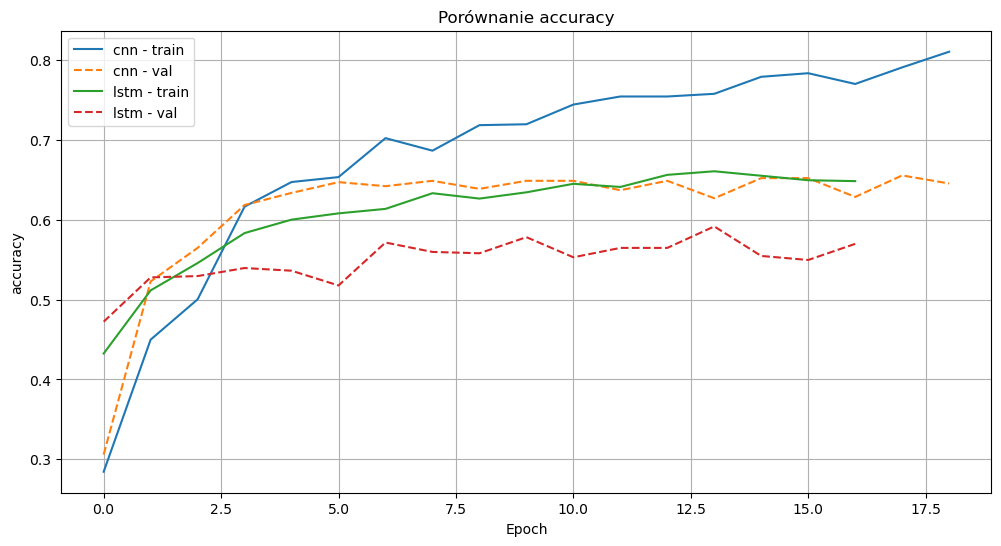

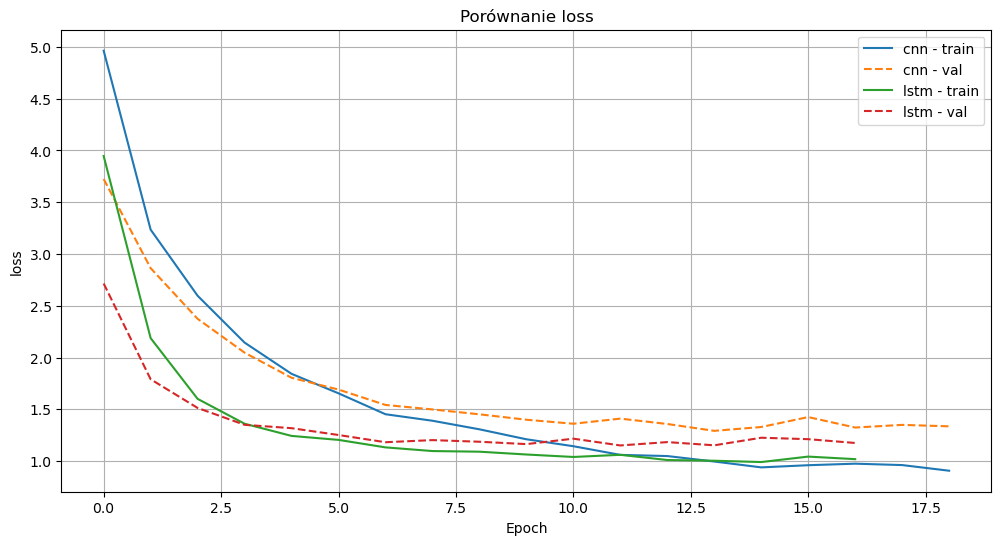

In [38]:
def plot_metric(histories, metric):
    plt.figure(figsize=(12, 6))
    
    for model_name, history in histories.items():
        plt.plot(history.history[metric], label=f'{model_name} - train')
        plt.plot(history.history[f'val_{metric}'], linestyle='--', label=f'{model_name} - val')
    
    plt.title(f'Porównanie {metric}')
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_metric(histories_no_weights, 'accuracy')
plot_metric(histories_no_weights, 'loss')

## Wyniki (tabela)

In [39]:

metrics_list_cnn_lstm = []
 


for model_name, model in trained_models_no_weights.items():
    print(f'Evaluating {model_name}...')
    # Ocena modelu na zbiorze testowym
    loss, accuracy, weighted_accuracy  = model.evaluate(X_test_scaled, Y_test )
    
    # Przewidywania na zbiorze testowym
    y_pred_probs = model.predict(X_test_scaled)
    y_pred_classes = np.argmax(y_pred_probs, axis=1)
    y_true_classes = np.argmax(Y_test, axis=1)
    
    # Obliczanie precyzji, recall, F1-score
    precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
    recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
    f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')
    #accuracy = accuracy_score(y_true_classes, y_pred_classes )
    
    # Dodanie metryk do listy
    metrics_list_cnn_lstm.append({
        'Model': model_name,
        'Accuracy': round(accuracy, 4),
        'Loss': round(loss, 4),
        'Precision': round(precision, 4),
        'Recall': round(recall, 4),
        'F1-score': round(f1, 4)
    })

# Tworzenie DataFrame z metrykami
metrics_df_cnn_lstm = pd.DataFrame(metrics_list_cnn_lstm)
metrics_df_cnn_lstm.set_index('Model', inplace=True)

# Wyświetlenie tabeli
print(metrics_df_cnn_lstm)

Evaluating cnn...
9/9 [==============================] - 0s 32ms/step
Evaluating lstm...
9/9 [==============================] - 1s 63ms/step
       Accuracy    Loss  Precision  Recall  F1-score
Model                                               
cnn      0.6049  1.4483     0.6222  0.6049    0.6110
lstm     0.4755  1.3499     0.5306  0.4755    0.4677


## ROC AUC

Evaluating cnn...
9/9 [==============================] - 0s 21ms/step
Model cnn having AUC-ROC (macro average): 0.8059


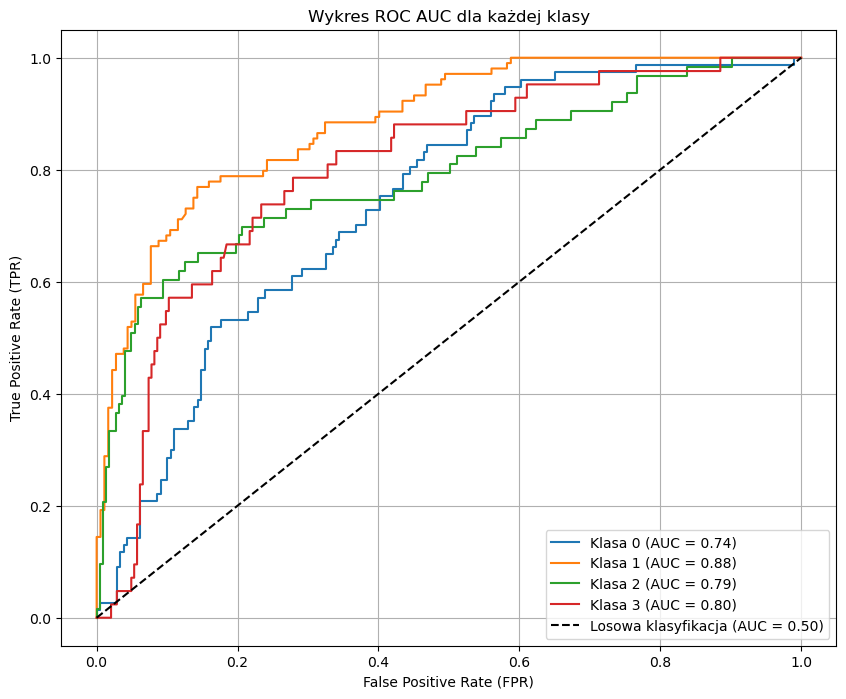

Evaluating lstm...
9/9 [==============================] - 1s 52ms/step
Model lstm having AUC-ROC (macro average): 0.7443


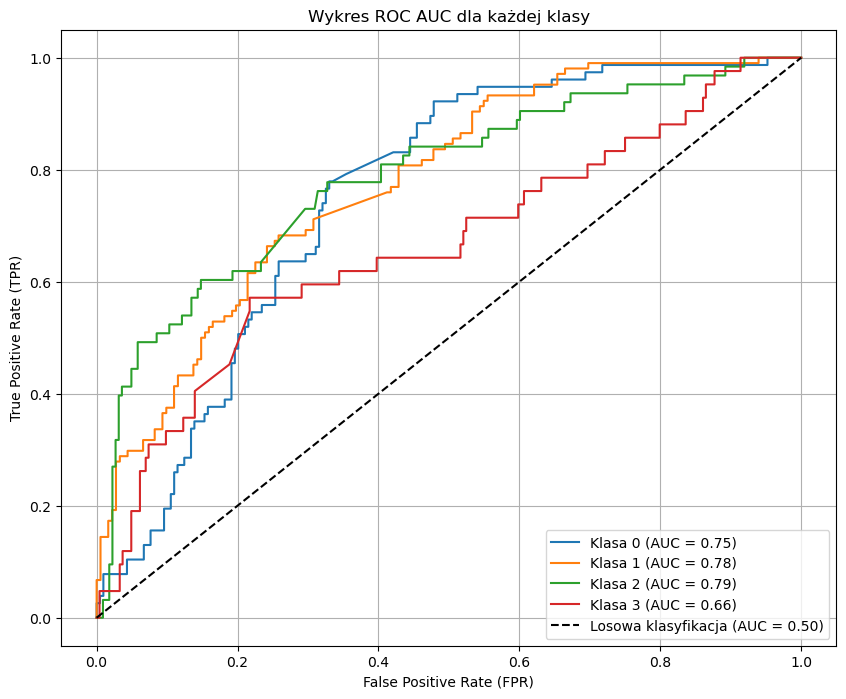

In [40]:
for model_name, model in trained_models_no_weights.items():
    print(f'Evaluating {model_name}...')
 
    y_pred_probs = model.predict(X_test_scaled)

    roc_auc = roc_auc_score(Y_test, y_pred_probs, average='macro', multi_class='ovr')           

    print(f"Model {model_name} having AUC-ROC (macro average): {roc_auc:.4f}")

    # Zakładając, że masz dane testowe i model wytrenowany
    num_classes = num_classes  # liczba klas
 
    # Konwersja prawdziwych etykiet do formatu one-hot, jeśli jeszcze nie są
    y_true_onehot = Y_test

    # Inicjalizacja wykresu
    plt.figure(figsize=(10, 8))

    # Obliczenie krzywych ROC dla każdej klasy
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_true_onehot[:, i], y_pred_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"Klasa {i} (AUC = {roc_auc:.2f})")

    # Dodanie przekątnej dla klasyfikacji losowej
    plt.plot([0, 1], [0, 1], 'k--', label='Losowa klasyfikacja (AUC = 0.50)')

    # Dostosowanie wykresu
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title("Wykres ROC AUC dla każdej klasy")
    plt.legend(loc="lower right")
    plt.grid()

    # Wyświetlenie wykresu
    plt.show()

Evaluating cnn...
9/9 [==============================] - 0s 32ms/step


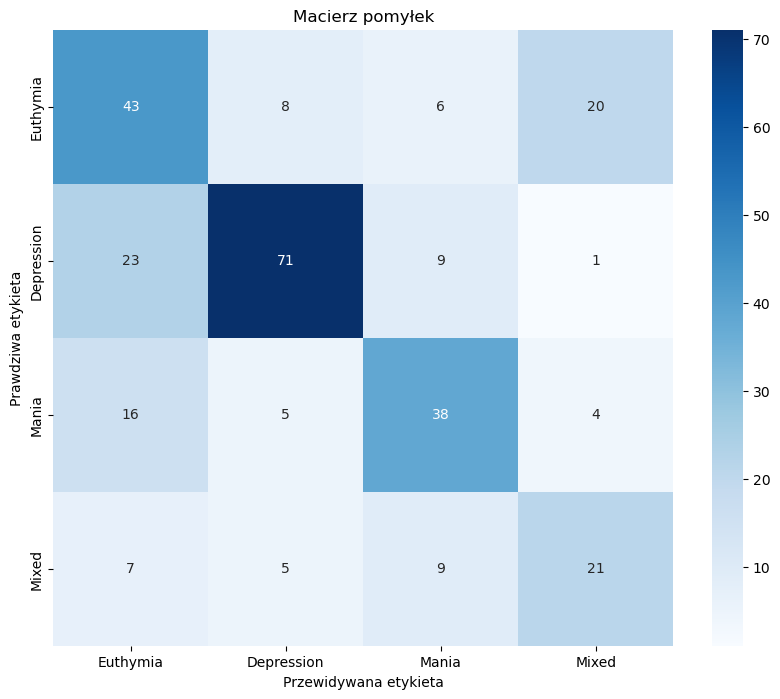

Evaluating lstm...
9/9 [==============================] - 1s 56ms/step


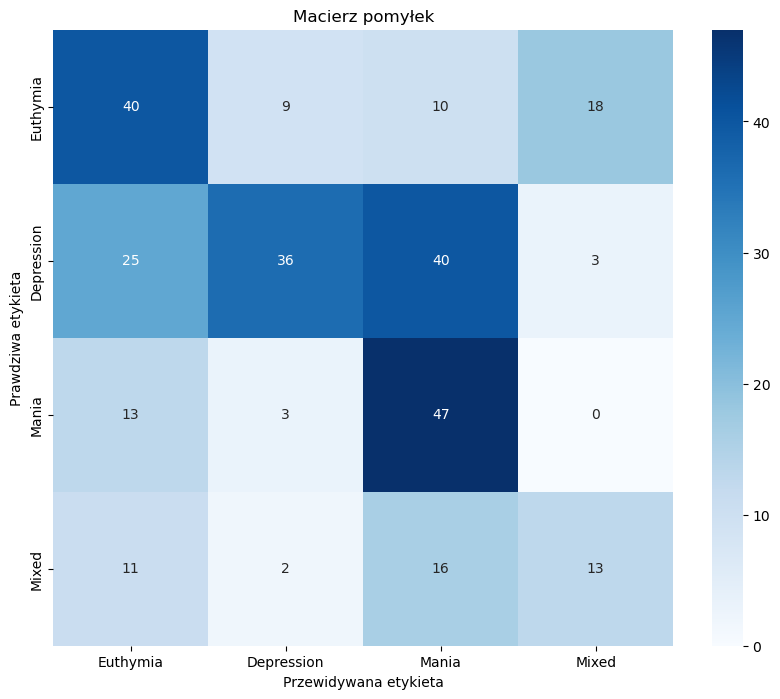

In [41]:
import seaborn as sns


for model_name, model in trained_models_no_weights.items():
    print(f'Evaluating {model_name}...')
 
    y_pred_probs = model.predict(X_test_scaled)
          

    #print(f"Model {model_name} having AUC-ROC (macro average): {roc_auc:.4f}")
 
    y_pred_classes = np.argmax(y_pred_probs, axis=1)

    # Prawdziwe etykiety
    # Jeśli y_test jest one-hot encoded
    y_true_classes = np.argmax(Y_test, axis=1)

    # Jeśli nie używasz LabelEncoder, zdefiniuj nazwy klas ręcznie
    class_names = ['Euthymia', 'Depression', 'Mania', 'Mixed' ]  # Zastąp odpowiednimi nazwami

    # Obliczenie macierzy pomyłek
    conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
    clas_report = classification_report(y_true_classes, y_pred_classes)

    # Wizualizacja macierzy pomyłek
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Macierz pomyłek')
    plt.xlabel('Przewidywana etykieta')
    plt.ylabel('Prawdziwa etykieta')
    plt.show()

# ANN

In [42]:
def plot_metric(histories, metric):
    plt.figure(figsize=(12, 6))
    
    for model_name, history in histories.items():
        plt.plot(history.history[metric], label=f'{model_name} - train')
        plt.plot(history.history[f'val_{metric}'], linestyle='--', label=f'{model_name} - val')
    
    plt.title(f'Porównanie {metric}')
    plt.xlabel('Epoka')
    plt.ylabel(metric)
    plt.legend()
    plt.grid(True)
    plt.show()

# Spłaszczenie danych

In [43]:
Y_train_flat = np.repeat(Y_train, 1000, axis=0)
Y_valid_flat = np.repeat(Y_valid, 1000, axis=0)
Y_test_flat = np.repeat(Y_test, 1000, axis=0)
valid_weights_flat = np.repeat(valid_weights, 1000, axis=0)
train_weights_flat = np.repeat(train_weights, 1000, axis=0)
X_valid_scaled_flat2 = X_valid_scaled_flat
X_train_scaled_flat2= X_train_scaled_flat

In [44]:
valid_symptoms_flat = np.repeat(valid_symptoms, 1000, axis=0)
train_symptoms_flat = np.repeat(train_symptoms, 1000, axis=0)

In [45]:
Y_train_int_flat = np.repeat(Y_train_int, 1000, axis=0)
Y_test_int_flat = np.repeat(Y_test_int, 1000, axis=0)
Y_valid_int_flat = np.repeat(Y_valid_int, 1000, axis=0)

## Definicja modelu ANN

In [60]:
# 2d. Definiowanie Modelu ANN - wymaga spłaszczonych danych
from tensorflow.keras.regularizers import l2
def create_ann_model(input_shape=(86,), num_classes=4):
    model = Sequential([
        Dense(64, activation='relu', input_shape=input_shape,  kernel_regularizer=l2(0.01)),
        Dropout(0.5),
        Dense(32, activation='relu',  kernel_regularizer=l2(0.01)),
        Dropout(0.4),
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer=tf.optimizers.Adam(learning_rate=0.002),
        loss='categorical_crossentropy',
        metrics=['accuracy']
        , weighted_metrics=['accuracy']
    )
    return model

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# Słownik funkcji budujących modele
model_builders_flat = {
    'ann': create_ann_model 
 
}

## Trenowanie modelu bez wag

In [62]:
import tensorflow as tf
import numpy as np
import random
import os

# Ustawienie zmiennych środowiskowych dla deterministycznych operacji
os.environ['PYTHONHASHSEED'] = '42'
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# Ustawienie seedów
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

from tensorflow.keras import models, layers, initializers

 
histories_flat_nw = {}
trained_models_flat_nw = {}


for model_name, build_function in model_builders_flat.items():
    print(f'Training {model_name}...')
    tf.random.set_seed(42)
    model = build_function()
    print("x")
    history = model.fit(
    X_train_scaled_flat2, Y_train_flat  ,
    epochs=5,
    batch_size=32,
    validation_data=(X_valid_scaled_flat2, Y_valid_flat  ),
    callbacks=[early_stopping],
    #sample_weight = train_weights_flat,
    verbose=1
    )
    histories_flat_nw[model_name] = history
    trained_models_flat_nw[model_name] = model  # Zapisujemy wytrenowany model
    print(f'{model_name} training completed.')



Training ann...
x
Epoch 1/5
55719/55719 [==============================] - 516s 9ms/step - loss: 1.1956 - accuracy: 0.5232 - weighted_accuracy: 0.5232 - val_loss: 1.1267 - val_accuracy: 0.5358 - val_weighted_accuracy: 0.5358
Epoch 2/5
55719/55719 [==============================] - 514s 9ms/step - loss: 1.1844 - accuracy: 0.5210 - weighted_accuracy: 0.5210 - val_loss: 1.1287 - val_accuracy: 0.5381 - val_weighted_accuracy: 0.5381
Epoch 3/5
55719/55719 [==============================] - 514s 9ms/step - loss: 1.1845 - accuracy: 0.5184 - weighted_accuracy: 0.5184 - val_loss: 1.1523 - val_accuracy: 0.5243 - val_weighted_accuracy: 0.5243
Epoch 4/5
55719/55719 [==============================] - 516s 9ms/step - loss: 1.1853 - accuracy: 0.5162 - weighted_accuracy: 0.5162 - val_loss: 1.1347 - val_accuracy: 0.5219 - val_weighted_accuracy: 0.5219
Epoch 5/5
55719/55719 [==============================] - 521s 9ms/step - loss: 1.1860 - accuracy: 0.5141 - weighted_accuracy: 0.5141 - val_loss: 1.1258 - 

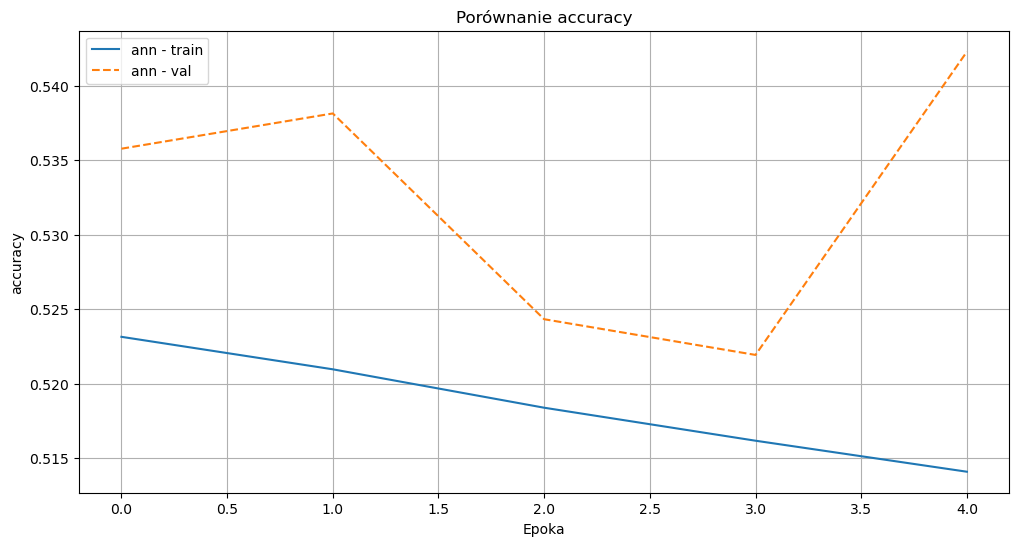

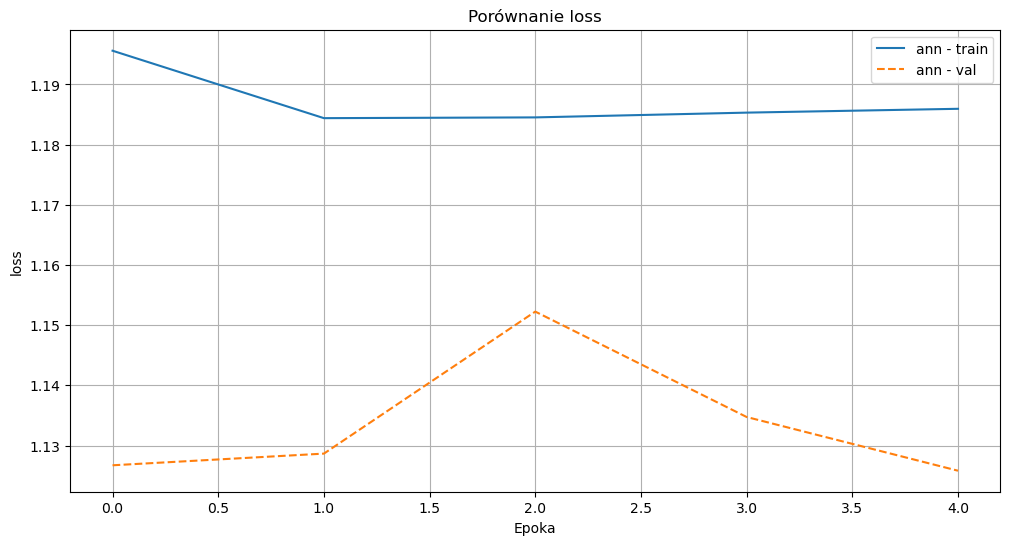

In [63]:

plot_metric(histories_flat_nw, 'accuracy')
plot_metric(histories_flat_nw, 'loss')

## Trenowanie modelu z wagami

In [49]:
# import tensorflow as tf
# import numpy as np
# import random
# import os

# # Ustawienie zmiennych środowiskowych dla deterministycznych operacji
# os.environ['PYTHONHASHSEED'] = '42'
# os.environ['TF_DETERMINISTIC_OPS'] = '1'

# # Ustawienie seedów
# tf.random.set_seed(42)
# np.random.seed(42)
# random.seed(42)

# from tensorflow.keras import models, layers, initializers

 
# histories_flat = {}
# trained_models_flat = {}


# for model_name, build_function in model_builders_flat.items():
#     print(f'Training {model_name}...')
#     tf.random.set_seed(42)
#     model = build_function()
#     print("x")
#     history = model.fit(
#     X_train_scaled_flat2, Y_train_flat  ,
#     epochs=15,
#     batch_size=64,
#     validation_data=(X_valid_scaled_flat2, Y_valid_flat , valid_weights_flat),
#     callbacks=[early_stopping],
#     sample_weight = train_weights_flat,
#     verbose=1
#     )
#     histories_flat[model_name] = history
#     trained_models_flat[model_name] = model  # Zapisujemy wytrenowany model
#     print(f'{model_name} training completed.')


In [50]:
# plot_metric(histories_flat, 'accuracy')
# plot_metric(histories_flat, 'loss')

## Porownanie wyników

### bez wag

In [64]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
import pandas as pd
import numpy as np


metrics_list_noweights = []
 


for model_name, model in trained_models_flat_nw.items():
    print(f'Evaluating {model_name}...')
    # Ocena modelu na zbiorze testowym
    loss, accuracy, weighted_accuracy = model.evaluate(X_test_scaled_flat, Y_test_flat )
    
    # Przewidywania na zbiorze testowym
    y_pred_probs = model.predict(X_test_scaled_flat)
    y_pred_classes = np.argmax(y_pred_probs, axis=1)
    y_true_classes = np.argmax(Y_test_flat, axis=1)
    
    # Obliczanie precyzji, recall, F1-score
    precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
    recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
    f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')
    
    # Dodanie metryk do listy
    metrics_list_noweights.append({
        'Model': model_name,
        'Accuracy': round(accuracy, 4),
        'Loss': round(loss, 4),
        'Precision': round(precision, 4),
        'Recall': round(recall, 4),
        'F1-score': round(f1, 4)
    })

# Tworzenie DataFrame z metrykami
metrics_df_noweights = pd.DataFrame(metrics_list_noweights)
metrics_df_noweights.set_index('Model', inplace=True)

# Wyświetlenie tabeli
print(metrics_df_noweights)

Evaluating ann...
8938/8938 [==============================] - 23s 3ms/step
       Accuracy    Loss  Precision  Recall  F1-score
Model                                               
ann      0.4367  1.2821     0.4962  0.4367    0.4179


### z wagami

In [52]:
# import matplotlib.pyplot as plt
# from sklearn.metrics import precision_score, recall_score, f1_score
# import pandas as pd
# import numpy as np


# metrics_list_weights = []
 


# for model_name, model in trained_models_flat.items():
#     print(f'Evaluating {model_name}...')
#     # Ocena modelu na zbiorze testowym
#     loss, accuracy, weighted_accuracy = model.evaluate(X_test_scaled_flat, Y_test_flat )
    
#     # Przewidywania na zbiorze testowym
#     y_pred_probs = model.predict(X_test_scaled_flat)
#     y_pred_classes = np.argmax(y_pred_probs, axis=1)
#     y_true_classes = np.argmax(Y_test_flat, axis=1)
    
#     # Obliczanie precyzji, recall, F1-score
#     precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
#     recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
#     f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')
    
#     # Dodanie metryk do listy
#     metrics_list_weights.append({
#         'Model': model_name,
#         'Accuracy': round(accuracy, 4),
#         'Loss': round(loss, 4),
#         'Precision': round(precision, 4),
#         'Recall': round(recall, 4),
#         'F1-score': round(f1, 4)
#     })

# # Tworzenie DataFrame z metrykami
# metrics_df_weights = pd.DataFrame(metrics_list_weights)
# metrics_df_weights.set_index('Model', inplace=True)

# # Wyświetlenie tabeli
# print(metrics_df_weights)

### bez wag 

Evaluating ann...
8938/8938 [==============================] - 24s 3ms/step
Model ann having AUC-ROC (macro average): 0.7071


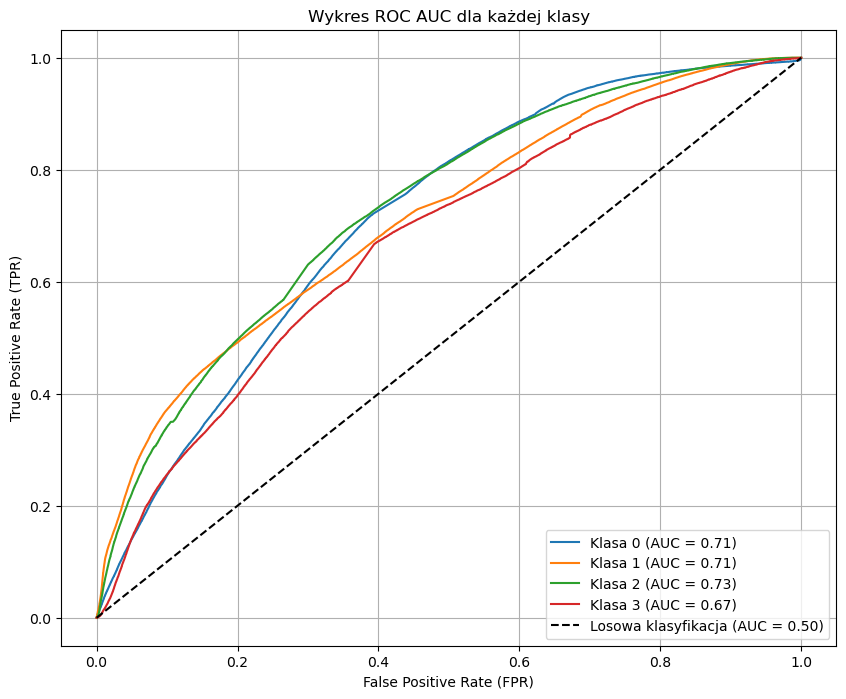

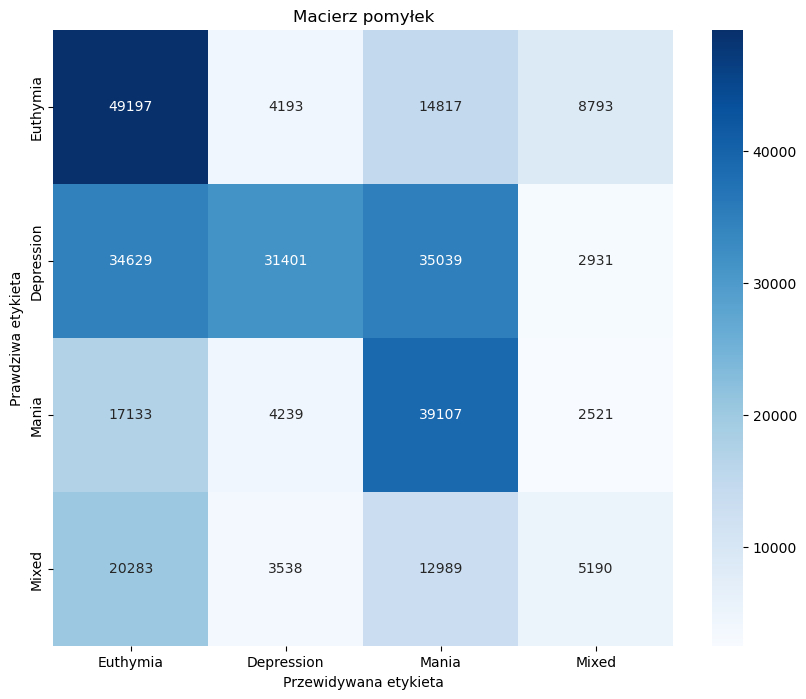

In [65]:
import seaborn as sns
for model_name, model in trained_models_flat_nw.items():
    print(f'Evaluating {model_name}...')
    # Ocena modelu na zbiorze testowym
    #loss, accuracy, weighted_accuracy  = model.evaluate(X_test_scaled, Y_test )
    
    # Przewidywania na zbiorze testowym
    y_pred_probs = model.predict(X_test_scaled_flat)

    roc_auc = roc_auc_score(Y_test_flat, y_pred_probs, average='macro', multi_class='ovr')           

    print(f"Model {model_name} having AUC-ROC (macro average): {roc_auc:.4f}")

    # Zakładając, że masz dane testowe i model wytrenowany
    num_classes = num_classes  # liczba klas
    
    y_pred_classes = np.argmax(y_pred_probs, axis=1)
    y_true_classes = np.argmax(Y_test_flat, axis=1)
    # Konwersja prawdziwych etykiet do formatu one-hot, jeśli jeszcze nie są
    y_true_onehot = Y_test_flat

    conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)  

    # Inicjalizacja wykresu
    plt.figure(figsize=(10, 8))

    # Obliczenie krzywych ROC dla każdej klasy
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_true_onehot[:, i], y_pred_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"Klasa {i} (AUC = {roc_auc:.2f})")

    # Dodanie przekątnej dla klasyfikacji losowej
    plt.plot([0, 1], [0, 1], 'k--', label='Losowa klasyfikacja (AUC = 0.50)')

    # Dostosowanie wykresu
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title("Wykres ROC AUC dla każdej klasy")
    plt.legend(loc="lower right")
    plt.grid()

    # Wyświetlenie wykresu
    plt.show()

    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                 xticklabels=class_names, yticklabels=class_names)
    plt.title('Macierz pomyłek')
    plt.xlabel('Przewidywana etykieta')
    plt.ylabel('Prawdziwa etykieta')
    plt.show()

### z wagami

In [54]:
# import seaborn as sns
# for model_name, model in trained_models_flat.items():
#     print(f'Evaluating {model_name}...')
#     # Ocena modelu na zbiorze testowym
#     #loss, accuracy, weighted_accuracy  = model.evaluate(X_test_scaled, Y_test )
    
#     # Przewidywania na zbiorze testowym
#     y_pred_probs = model.predict(X_test_scaled_flat)

#     roc_auc = roc_auc_score(Y_test_flat, y_pred_probs, average='macro', multi_class='ovr')           

#     print(f"Model {model_name} having AUC-ROC (macro average): {roc_auc:.4f}")

#     # Zakładając, że masz dane testowe i model wytrenowany
#     num_classes = num_classes  # liczba klas
    
#     y_pred_classes = np.argmax(y_pred_probs, axis=1)
#     y_true_classes = np.argmax(Y_test_flat, axis=1)
#     # Konwersja prawdziwych etykiet do formatu one-hot, jeśli jeszcze nie są
#     y_true_onehot = Y_test_flat

#     conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)  

#     # Inicjalizacja wykresu
#     plt.figure(figsize=(10, 8))

#     # Obliczenie krzywych ROC dla każdej klasy
#     for i in range(num_classes):
#         fpr, tpr, _ = roc_curve(y_true_onehot[:, i], y_pred_probs[:, i])
#         roc_auc = auc(fpr, tpr)
#         plt.plot(fpr, tpr, label=f"Klasa {i} (AUC = {roc_auc:.2f})")

#     # Dodanie przekątnej dla klasyfikacji losowej
#     plt.plot([0, 1], [0, 1], 'k--', label='Losowa klasyfikacja (AUC = 0.50)')

#     # Dostosowanie wykresu
#     plt.xlabel("False Positive Rate (FPR)")
#     plt.ylabel("True Positive Rate (TPR)")
#     plt.title("Wykres ROC AUC dla każdej klasy")
#     plt.legend(loc="lower right")
#     plt.grid()

#     # Wyświetlenie wykresu
#     plt.show()

#     plt.figure(figsize=(10, 8))
#     sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
#                  xticklabels=class_names, yticklabels=class_names)
#     plt.title('Macierz pomyłek')
#     plt.xlabel('Przewidywana etykieta')
#     plt.ylabel('Prawdziwa etykieta')
#     plt.show()

# Wykresy do pracy

In [66]:
# połącznie danych : 
histories_no_weights['ann']   = histories_flat_nw['ann'] 
trained_models_no_weights['ann']  = trained_models_flat_nw['ann']  
    

## Połączenie CNN, LSTM, ANN - LOSS

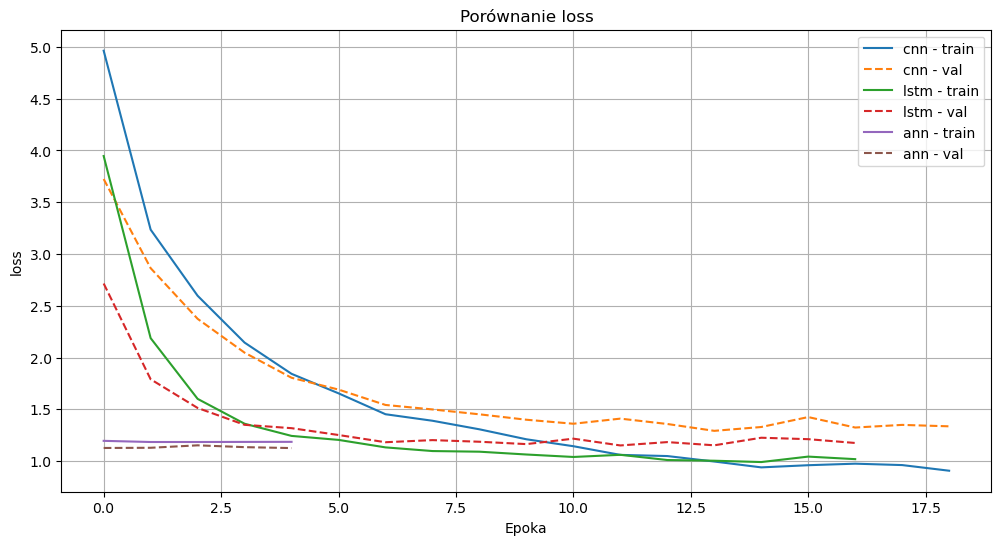

In [67]:
plot_metric(histories_no_weights, 'loss')

## PLENARY

In [57]:

# model_name='two_head'

# input = tf.keras.layers.Input(shape=(86,), name='input')
# hidden = tf.keras.layers.Dense(64, activation='relu', name='dense')(input)
# dropout = tf.keras.layers.Dropout(0.2, name='dropout')(hidden)
# symptom_output = tf.keras.layers.Dense(10, name='symptom_output')(dropout)
# state_output = tf.keras.layers.Dense(4, activation='softmax', name='state_output')(symptom_output)

# two_head = tf.keras.Model(inputs=input, 
#                           outputs=[symptom_output, state_output], 
#                           name='two_head_model')

# two_head.summary()

# two_head.compile(optimizer='adam',
#                  loss=[tf.keras.losses.MeanAbsoluteError(),
#                        tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)],
#                  loss_weights=[0.5, 0.5],
#                  metrics=['mae', 'accuracy'])

# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='state_output_accuracy', patience=3)

# two_head.fit(X_train_scaled, [y_train_symptoms, y_train_states_encoded], epochs=15, 
#              validation_data=(X_test_scaled, [y_test_symptoms, y_test_states_encoded]),
#              callbacks=[early_stopping])

In [68]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanAbsoluteError, SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping

def create_plenary_model(input_shape=(86,), num_classes=4):
    # Define the input layer
    input_layer = Input(shape=input_shape, name='input')
    
    # Hidden layers
    hidden = Dense(64, activation='relu', name='dense')(input_layer)
    dropout = Dropout(0.2, name='dropout')(hidden)
    
    # First output: Symptom Prediction (Regression)
    symptom_output = Dense(10, name='symptom_output')(dropout)
    
    # Second output: State Prediction (Classification)
    state_output = Dense(num_classes, activation='softmax', name='state_output')(symptom_output)
    
    # Create the model with two outputs
    model = Model(inputs=input_layer, outputs=[symptom_output, state_output], name='plenary_model')
    
    # Compile the model with appropriate loss functions and metrics
    model.compile(
        optimizer=Adam(learning_rate=0.002),
        loss={
            'symptom_output': MeanAbsoluteError(),
            'state_output': SparseCategoricalCrossentropy(from_logits=False)
        },
        loss_weights={
            'symptom_output': 0.5,
            'state_output': 0.5
        },
        metrics={
            'symptom_output': ['mae'],
            'state_output': ['accuracy']
        }
    )
    
    return model
       

In [69]:
gc.collect()

6697

In [70]:
 
early_stopping = EarlyStopping(monitor='state_output_accuracy', patience=5, restore_best_weights=True)
# Słownik funkcji budujących modele
model_builders_plenary = {
    'plenary': create_plenary_model 
 
}

## Plenary z wagami

In [71]:
import tensorflow as tf
import numpy as np
import random
import os

# Ustawienie zmiennych środowiskowych dla deterministycznych operacji
#os.environ['PYTHONHASHSEED'] = '42'
#os.environ['TF_DETERMINISTIC_OPS'] = '1'

# Ustawienie seedów
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

from tensorflow.keras import models, layers, initializers

 
histories_flat_plenary = {}
trained_models_flat_plenary = {}


for model_name, build_function in model_builders_plenary.items():
    print(f'Training {model_name}...')
 
    tf.random.set_seed(42)
    model = build_function()
    print("x")
    history = model.fit(
    X_train_scaled_flat2 ,
     {
            'symptom_output': train_symptoms_flat,
            'state_output': Y_train_int_flat
        },
    epochs=10,
    batch_size=32,
    validation_data=(
            X_valid_scaled_flat2,
            {
                'symptom_output': valid_symptoms_flat,
                'state_output': Y_valid_int_flat
            },
            valid_weights_flat
        ),
    callbacks=[early_stopping],
    sample_weight={
            'symptom_output': train_weights_flat,
            'state_output': train_weights_flat
        },
    verbose=1
    )
    histories_flat_plenary[model_name] = history
    trained_models_flat_plenary[model_name] = model  # Zapisujemy wytrenowany model
    print(f'{model_name} training completed.')

Training plenary...
x
Epoch 1/10


UnimplementedError: Graph execution error:

Detected at node 'gradient_tape/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/UnsortedSegmentSum' defined at (most recent call last):
    File "c:\Users\user\anaconda3\envs\phd\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\user\anaconda3\envs\phd\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "c:\Users\user\anaconda3\envs\phd\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "c:\Users\user\anaconda3\envs\phd\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "c:\Users\user\anaconda3\envs\phd\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "c:\Users\user\anaconda3\envs\phd\lib\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\user\anaconda3\envs\phd\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "c:\Users\user\anaconda3\envs\phd\lib\asyncio\base_events.py", line 1909, in _run_once
      handle._run()
    File "c:\Users\user\anaconda3\envs\phd\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\user\anaconda3\envs\phd\lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "c:\Users\user\anaconda3\envs\phd\lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "c:\Users\user\anaconda3\envs\phd\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "c:\Users\user\anaconda3\envs\phd\lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request
      await super().execute_request(stream, ident, parent)
    File "c:\Users\user\anaconda3\envs\phd\lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "c:\Users\user\anaconda3\envs\phd\lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute
      res = shell.run_cell(
    File "c:\Users\user\anaconda3\envs\phd\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\user\anaconda3\envs\phd\lib\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell
      result = self._run_cell(
    File "c:\Users\user\anaconda3\envs\phd\lib\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell
      result = runner(coro)
    File "c:\Users\user\anaconda3\envs\phd\lib\site-packages\IPython\core\async_helpers.py", line 128, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\user\anaconda3\envs\phd\lib\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\user\anaconda3\envs\phd\lib\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\user\anaconda3\envs\phd\lib\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\user\AppData\Local\Temp\ipykernel_6376\1487749544.py", line 28, in <module>
      history = model.fit(
    File "c:\Users\user\anaconda3\envs\phd\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\user\anaconda3\envs\phd\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\user\anaconda3\envs\phd\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\user\anaconda3\envs\phd\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\user\anaconda3\envs\phd\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\user\anaconda3\envs\phd\lib\site-packages\keras\engine\training.py", line 997, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "c:\Users\user\anaconda3\envs\phd\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 576, in minimize
      grads_and_vars = self._compute_gradients(
    File "c:\Users\user\anaconda3\envs\phd\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 634, in _compute_gradients
      grads_and_vars = self._get_gradients(
    File "c:\Users\user\anaconda3\envs\phd\lib\site-packages\keras\optimizers\optimizer_v2\optimizer_v2.py", line 510, in _get_gradients
      grads = tape.gradient(loss, var_list, grad_loss)
Node: 'gradient_tape/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/UnsortedSegmentSum'
Deterministic GPU implementation of unsorted segment reduction op not available.
	 [[{{node gradient_tape/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/UnsortedSegmentSum}}]] [Op:__inference_train_function_5051677]

In [46]:
gc.collect()

5134

In [ ]:
print("AXXXXXX")

AXXXXXX


: 

In [ ]:
import tensorflow as tf
import numpy as np
import random
import os

# Ustawienie zmiennych środowiskowych dla deterministycznych operacji
#os.environ['PYTHONHASHSEED'] = '42'
#os.environ['TF_DETERMINISTIC_OPS'] = '1'

# Ustawienie seedów
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

from tensorflow.keras import models, layers, initializers

 
histories_flat_plenary_nw = {}
trained_models_flat_plenary_nw = {}


for model_name, build_function in model_builders_plenary.items():
    print(f'Training {model_name}...')
 
    tf.random.set_seed(42)
    model = build_function()
    print("x")
    history = model.fit(
    X_train_scaled_flat2 ,
     {
            'symptom_output': train_symptoms_flat,
            'state_output': Y_train_int_flat
        },
    epochs=10,
    batch_size=32,
    validation_data=(
            X_valid_scaled_flat2,
            {
                'symptom_output': valid_symptoms_flat,
                'state_output': Y_valid_int_flat
            },
            valid_weights_flat
        ),
    callbacks=[early_stopping],
    sample_weight={
            'symptom_output': train_weights_flat,
            'state_output': train_weights_flat
        },
    verbose=1
    )
    histories_flat_plenary_nw[model_name] = history
    trained_models_flat_plenary_nw[model_name] = model  # Zapisujemy wytrenowany model
    print(f'{model_name} training completed.')

Training plenary...
x
Epoch 1/10
55719/55719 [==============================] - 1030s 18ms/step - loss: 0.3091 - symptom_output_loss: 0.1801 - state_output_loss: 0.4380 - symptom_output_mae: 0.4573 - state_output_accuracy: 0.5243 - val_loss: 0.3354 - val_symptom_output_loss: 0.1917 - val_state_output_loss: 0.4790 - val_symptom_output_mae: 0.4461 - val_state_output_accuracy: 0.5064
Epoch 2/10
55719/55719 [==============================] - 674s 12ms/step - loss: 0.2962 - symptom_output_loss: 0.1728 - state_output_loss: 0.4196 - symptom_output_mae: 0.4405 - state_output_accuracy: 0.5374 - val_loss: 0.3338 - val_symptom_output_loss: 0.1904 - val_state_output_loss: 0.4773 - val_symptom_output_mae: 0.4411 - val_state_output_accuracy: 0.5174
Epoch 3/10
55719/55719 [==============================] - 675s 12ms/step - loss: 0.2929 - symptom_output_loss: 0.1713 - state_output_loss: 0.4146 - symptom_output_mae: 0.4363 - state_output_accuracy: 0.5411 - val_loss: 0.3351 - val_symptom_output_loss: 0.

In [44]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
import pandas as pd
import numpy as np


metrics_list_weights_plenary_nw = []
 


for model_name, model in trained_models_flat_plenary_nw.items():
    print(f'Evaluating {model_name}...')
    # Ocena modelu na zbiorze testowym
    loss, mae, accuracy, weighted_mae, weighted_accuracy = model.evaluate(X_test_scaled_flat, Y_test_flat )
    
    # Przewidywania na zbiorze testowym
    y_pred_probs = model.predict(X_test_scaled_flat)
    y_pred_classes = np.argmax(y_pred_probs, axis=1)
    y_true_classes = np.argmax(Y_test_flat, axis=1)
    # Obliczanie precyzji, recall, F1-score
    precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
    recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
    f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')
    
    # Dodanie metryk do listy
    metrics_list_weights_plenary_nw.append({
        'Model': model_name,
        'Accuracy': round(accuracy, 4),
        'Loss': round(loss, 4),
        'Precision': round(precision, 4),
        'Recall': round(recall, 4),
        'F1-score': round(f1, 4)
    })

# Tworzenie DataFrame z metrykami
metrics_df_weights_plenary_nw = pd.DataFrame(metrics_list_weights_plenary_nw)
metrics_df_weights_plenary_nw.set_index('Model', inplace=True)

# Wyświetlenie tabeli
print(metrics_df_weights_plenary_nw)

Evaluating plenary...


ValueError: in user code:

    File "c:\Users\user\anaconda3\envs\phd\lib\site-packages\keras\engine\training.py", line 1727, in test_function  *
        return step_function(self, iterator)
    File "c:\Users\user\anaconda3\envs\phd\lib\site-packages\keras\engine\training.py", line 1713, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\user\anaconda3\envs\phd\lib\site-packages\keras\engine\training.py", line 1701, in run_step  **
        outputs = model.test_step(data)
    File "c:\Users\user\anaconda3\envs\phd\lib\site-packages\keras\engine\training.py", line 1667, in test_step
        self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\user\anaconda3\envs\phd\lib\site-packages\keras\engine\training.py", line 1052, in compute_loss
        return self.compiled_loss(
    File "c:\Users\user\anaconda3\envs\phd\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\user\anaconda3\envs\phd\lib\site-packages\keras\losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "c:\Users\user\anaconda3\envs\phd\lib\site-packages\keras\losses.py", line 272, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\user\anaconda3\envs\phd\lib\site-packages\keras\losses.py", line 1627, in mean_absolute_error
        return backend.mean(tf.abs(y_pred - y_true), axis=-1)

    ValueError: Dimensions must be equal, but are 10 and 4 for '{{node mean_absolute_error/sub}} = Sub[T=DT_FLOAT](plenary_model/symptom_output/BiasAdd, IteratorGetNext:1)' with input shapes: [?,10], [?,4].


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
import pandas as pd
import numpy as np


metrics_list_plenary_w = []
 


for model_name, model in trained_models_flat_plenary.items():
    print(f'Evaluating {model_name}...')
    # Ocena modelu na zbiorze testowym
    loss, mae, accuracy, weighted_mae, weighted_accuracy = model.evaluate(X_test_scaled_flat, Y_test_flat )
    
    # Przewidywania na zbiorze testowym
    y_pred_probs = model.predict(X_test_scaled_flat)
    y_pred_classes = np.argmax(y_pred_probs, axis=1)
    y_true_classes = np.argmax(Y_test_flat, axis=1)
    
    # Obliczanie precyzji, recall, F1-score
    precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
    recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
    f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')
    
    # Dodanie metryk do listy
    metrics_list_plenary_w.append({
        'Model': model_name,
        'Accuracy': round(accuracy, 4),
        'Loss': round(loss, 4),
        'Precision': round(precision, 4),
        'Recall': round(recall, 4),
        'F1-score': round(f1, 4)
    })

# Tworzenie DataFrame z metrykami
metrics_df_plenary_w = pd.DataFrame(metrics_list_plenary_w)
metrics_df_plenary_w.set_index('Model', inplace=True)

# Wyświetlenie tabeli
print(metrics_df_plenary_w)

## wykresy dla plenary

In [ ]:
plot_metric(histories_flat_plenary, 'loss')
plot_metric(histories_flat_plenary_nw, 'loss')

In [ ]:

plt.figure(figsize=(12, 6))
    
 
plt.plot(histories_flat_plenary['plenary'].history['loss'], label=f'{model_name}_cf - train')
plt.plot(histories_flat_plenary['plenary'].history['val_loss'],linestyle='--', label=f'{model_name}_cf - valid')
plt.plot(histories_flat_plenary_nw['plenary'].history['loss'], label=f'{model_name} - train')
plt.plot(histories_flat_plenary_nw['plenary'].history['val_loss'],linestyle='--', label=f'{model_name} - valid')
 
    
plt.title(f'Loss comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import seaborn as sns
for model_name, model in trained_models_flat_plenary.items():
    print(f'Evaluating {model_name}...')
    # Ocena modelu na zbiorze testowym
    #loss, accuracy, weighted_accuracy  = model.evaluate(X_test_scaled, Y_test )
    
    # Przewidywania na zbiorze testowym
    y_pred_probs = model.predict(X_test_scaled_flat)

    roc_auc = roc_auc_score(Y_test_flat, y_pred_probs, average='macro', multi_class='ovr')           

    print(f"Model {model_name} having AUC-ROC (macro average): {roc_auc:.4f}")

    # Zakładając, że masz dane testowe i model wytrenowany
    num_classes = num_classes  # liczba klas
    
    y_pred_classes = np.argmax(y_pred_probs, axis=1)
    y_true_classes = np.argmax(Y_test_flat, axis=1)
    # Konwersja prawdziwych etykiet do formatu one-hot, jeśli jeszcze nie są
    y_true_onehot = Y_test_flat

    conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)  

    # Inicjalizacja wykresu
    plt.figure(figsize=(10, 8))

    # Obliczenie krzywych ROC dla każdej klasy
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_true_onehot[:, i], y_pred_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"Klasa {i} (AUC = {roc_auc:.2f})")

    # Dodanie przekątnej dla klasyfikacji losowej
    plt.plot([0, 1], [0, 1], 'k--', label='Losowa klasyfikacja (AUC = 0.50)')

    # Dostosowanie wykresu
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title("Wykres ROC AUC dla każdej klasy")
    plt.legend(loc="lower right")
    plt.grid()

    # Wyświetlenie wykresu
    plt.show()

    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                 xticklabels=class_names, yticklabels=class_names)
    plt.title('Macierz pomyłek')
    plt.xlabel('Przewidywana etykieta')
    plt.ylabel('Prawdziwa etykieta')
    plt.show()

In [ ]:
import seaborn as sns
for model_name, model in trained_models_flat_plenary_nw.items():
    print(f'Evaluating {model_name}...')
    # Ocena modelu na zbiorze testowym
    #loss, accuracy, weighted_accuracy  = model.evaluate(X_test_scaled, Y_test )
    
    # Przewidywania na zbiorze testowym
    y_pred_probs = model.predict(X_test_scaled_flat)

    roc_auc = roc_auc_score(Y_test_flat, y_pred_probs, average='macro', multi_class='ovr')           

    print(f"Model {model_name} having AUC-ROC (macro average): {roc_auc:.4f}")

    # Zakładając, że masz dane testowe i model wytrenowany
    num_classes = num_classes  # liczba klas
    
    y_pred_classes = np.argmax(y_pred_probs, axis=1)
    y_true_classes = np.argmax(Y_test_flat, axis=1)
    # Konwersja prawdziwych etykiet do formatu one-hot, jeśli jeszcze nie są
    y_true_onehot = Y_test_flat

    conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)  

    # Inicjalizacja wykresu
    plt.figure(figsize=(10, 8))

    # Obliczenie krzywych ROC dla każdej klasy
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_true_onehot[:, i], y_pred_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"Klasa {i} (AUC = {roc_auc:.2f})")

    # Dodanie przekątnej dla klasyfikacji losowej
    plt.plot([0, 1], [0, 1], 'k--', label='Losowa klasyfikacja (AUC = 0.50)')

    # Dostosowanie wykresu
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title("Wykres ROC AUC dla każdej klasy")
    plt.legend(loc="lower right")
    plt.grid()

    # Wyświetlenie wykresu
    plt.show()

    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                 xticklabels=class_names, yticklabels=class_names)
    plt.title('Macierz pomyłek')
    plt.xlabel('Przewidywana etykieta')
    plt.ylabel('Prawdziwa etykieta')
    plt.show()

In [ ]:

# model_name='two_head'

# input = tf.keras.layers.Input(shape=(86,), name='input')
# hidden = tf.keras.layers.Dense(64, activation='relu', name='dense')(input)
# dropout = tf.keras.layers.Dropout(0.2, name='dropout')(hidden)
# symptom_output = tf.keras.layers.Dense(10, name='symptom_output')(dropout)
# state_output = tf.keras.layers.Dense(4, activation='softmax', name='state_output')(symptom_output)

# two_head = tf.keras.Model(inputs=input, 
#                           outputs=[symptom_output, state_output], 
#                           name='two_head_model')

# two_head.summary()

# two_head.compile(optimizer='adam',
#                  loss=[tf.keras.losses.MeanAbsoluteError(),
#                        tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)],
#                  loss_weights=[0.5, 0.5],
#                  metrics=['mae', 'accuracy'])

# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='state_output_accuracy', patience=3)

# two_head.fit(X_train_scaled, [y_train_symptoms, y_train_states_encoded], epochs=15, 
#              validation_data=(X_test_scaled, [y_test_symptoms, y_test_states_encoded]),
#              callbacks=[early_stopping])

In [ ]:
# model_name='two_head'
# y_pred_states = two_head.predict(X_test_scaled)

# y_pred_states = np.argmax(y_pred_states[1][:], axis=1)

# cm_th_class = confusion_matrix(y_test_states_encoded, y_pred_states)
# cr_th_class = classification_report(y_test_states_encoded, y_pred_states)

# print(cm_th_class)
# print(cr_th_class)

## SHAP

In [ ]:
import shap

In [ ]:
print("X_train_scaled_flat2 shape:", X_train_scaled_flat2.shape)
print("X_test_scaled shape:", X_test_scaled_flat.shape)

In [ ]:
# #prepare data for shap
X_train_summary = shap.sample(X_train_scaled_flat2, 100)
end = len(X_test_scaled)
model = trained_models_flat_plenary['plenary']
# feature_names = X_train_scaled_flat2.columns 
# classes_names_states = list(label_coding.keys())

# data_shap_df=pd.DataFrame(X_test_scaled[1:end:100,:], columns = feature_names)

In [ ]:
explainer = shap.KernelExplainer(model.predict, X_train_summary)

#explainer = shap.KernelExplainer(trained_models_flat_plenary['plenary']  , X_train_summary)  
shap_values = explainer.shap_values(X_test_scaled_flat[1 :100, : ]) 

In [ ]:
# #decoding values of BD stated to BD name
# classes_names_states = []
# for label in y_test_states_encoded:
#      classes_names_states.append(list(label_coding.keys())[list(label_coding.values()).index(label)])

In [ ]:
shap.summary_plot(shap_values, X_test_scaled_flat[1 :100, : ], plot_type="bar" ) # class_names= classes_names_states,
                     #feature_names = feature_names, max_display=max_features , show=False)

In [ ]:
# #I'm plotting the global explanation for all classes, varying the number of features to share
# model_name='two_head'
# for max_features in [20, 40, 86]: 
#   shap.summary_plot(shap_values, X_test_scaled[1:end:100,:], plot_type="bar", class_names= classes_names_states,
#                     feature_names = feature_names, max_display=max_features , show=False)
#   plt.gcf()
#   figname=graphsStreamPath+model_name+'_global_allclasses_states_'+str(max_features)+'.png'
#   plt.savefig(figname,dpi=150, bbox_inches='tight')
#   plt.plot()
#   plt.clf()

# #I'm plotting the global explanations for all the classes, varying the number of features to show
# #I'm iterating on the number of classes (numerical)
# for class_id in range(len(shap_values)):
#   #I'm iterating on the number of features I want to plot
#   for max_features in [20, 40, 86]: 
#     shap.summary_plot(shap_values[class_id], X_test_scaled[1:end:100,:], feature_names = feature_names, max_display=max_features,show=False)
#     plt.gcf()
#     figname=graphsStreamPath+model_name+'_global_class'+str(class_id)+'_features'+ str(max_features)+'.png'
#     plt.savefig(figname,dpi=150, bbox_inches='tight')
#     plt.plot()
#     plt.clf()

### SHAP with symptoms

In [ ]:
# #prepare data for shap
# X_train_summary = shap.sample(X_train_scaled, 100)
# end = len(X_test_scaled)
# feature_names=X_test.columns 
# classes_names_states= list(label_coding.keys())

# data_shap_th=pd.DataFrame(X_test_scaled[1:end:100,:], columns = feature_names)
# data_shap_th.to_csv(shapvaluesStreamPath + "/data_shap_twohead.csv", index=False)

In [ ]:
# def f_symptoms(X):
#     return two_head.predict(X)[0]# with this function we select the first output of the model: vector of symptoms 

# explainer = shap.KernelExplainer(f_symptoms, X_train_summary)
# shap_values = explainer.shap_values(X_test_scaled[1:end:100,:]) 
# classes_names=y_test_symptoms.columns

In [ ]:
# max_features=20
# #I'm plotting the global summary for all the classes, only for 20 features
# shap.summary_plot(shap_values, X_test_scaled[1:end:100,:], plot_type="bar", 
#                   class_names= classes_names, max_display=max_features, feature_names = feature_names,show=False)
# plt.gcf()
# figname=graphsStreamPath+model_name+'_global_allclasses.png'
# plt.savefig(figname,dpi=150, bbox_inches='tight')
# plt.clf()

# for x in range(classes_names.shape[0]):
#   classes_names[x]
#   shap.summary_plot(shap_values[x], X_test_scaled[1:end:100,:], feature_names = feature_names,
#                     max_display=max_features,show=False) #you can change the maximum features to display 
#   plt.gcf()
#   figname=graphsStreamPath+model_name+'_global_allclasses_'+classes_names[x]+'.png'
#   plt.savefig(figname,dpi=150, bbox_inches='tight')
#   plt.clf()